In [133]:
import torch
from torch import nn

In [134]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [263]:
import os
from PIL import Image

# Set the path to the directory
path = r'C:\Users\Krumomir\Downloads\RSCD dataset-1million\train'

# Initialize an empty list to store the subdirectories
subdirs = []

# Loop through all the directories and files in the directory
for dirpath, dirnames, filenames in os.walk(path):
 # Loop through all the subdirectories
     for dirname in dirnames:
         # Append the subdirectory to the list
        subdirs.append(os.path.join(dirpath, dirname))

# Initialize an empty list to store the images
image_list = []
counter = 0

labels_names = ['dry', 'fresh', 'ice', 'melted', 'water', 'wet']
dictionary = {}

for counter in range(len(subdirs)):
  # Loop through all the files in the directory
  for filename in os.listdir(subdirs[counter]):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.png'):
        for name in labels_names:
            if name in filename:
                if name not in dictionary:
                    dictionary[name] = []
                dictionary[name].append(subdirs[counter] + "/" + filename)

In [264]:
for name in labels_names:
    print(f'{name} - {len(dictionary[name])}')

dry - 355509
fresh - 73560
ice - 54092
melted - 61093
water - 147257
wet - 267486


In [265]:
import random

dict2 = {}

for name in labels_names:
    if name not in dict2:
        dict2[name] = []
    random.shuffle(dictionary[name])
    dict2[name] = dictionary[name][:10000]

In [266]:
for name in labels_names:
    print(f'{name} - {len(dict2[name])}')

dry - 4092
fresh - 4092
ice - 4092
melted - 4092
water - 4092
wet - 4092


In [281]:
import os
from PIL import Image

image_list = []

arr = []

for name in dict2:
    for filename in dict2[name]:
        arr.append(filename)

# Loop through all the files in the directory
for filename in arr:
    print(filename)
    img = Image.open(filename).copy()
    # Append the image to the list
    image_list.append(img)

C:\Users\Krumomir\Downloads\RSCD dataset-1million\train\dry_asphalt_smooth/2022021011403914-dry-asphalt-smooth.jpg
C:\Users\Krumomir\Downloads\RSCD dataset-1million\train\dry_gravel/20220311141321379-dry-gravel.jpg
C:\Users\Krumomir\Downloads\RSCD dataset-1million\train\dry_gravel/20220311140941242-dry-gravel.jpg
C:\Users\Krumomir\Downloads\RSCD dataset-1million\train\dry_gravel/202204261615087-dry-gravel.jpg
C:\Users\Krumomir\Downloads\RSCD dataset-1million\train\dry_concrete_smooth/202207021449221513-dry-concrete-smooth.jpg
C:\Users\Krumomir\Downloads\RSCD dataset-1million\train\dry_asphalt_slight/202203201412582-dry-asphalt-slight.jpg
C:\Users\Krumomir\Downloads\RSCD dataset-1million\train\dry_concrete_slight/20220318211518428-dry-concrete-slight.jpg
C:\Users\Krumomir\Downloads\RSCD dataset-1million\train\dry_asphalt_severe/202202122132152-dry-asphalt-severe.jpg
C:\Users\Krumomir\Downloads\RSCD dataset-1million\train\dry_concrete_smooth/20220711201815244-dry-concrete-smooth.jpg
C:\U

In [286]:
labels = []

for filename in arr:
    for name in labels_names:
        if name in filename:
            labels.append(name)
            break

# for filename in arr:
#   labels.append([name for name in labels_names if name in filename])
#   if 1 < len([name for name in labels_names if name in filename]):
#     print(filename)

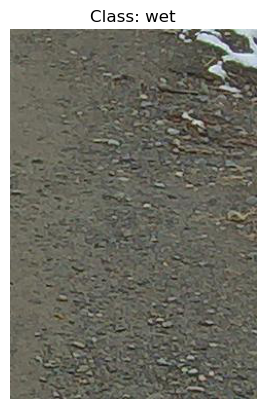

In [295]:
for name in labels_names:
    image_path = dict2[name][torch.randint(0, len(dict2[name]), size=[1])]

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255. 

    model.to(device)
    
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    title = f"Class: {name}"
    plt.title(title)
    plt.axis(False);

In [297]:
# import matplotlib.pyplot as plt

# # Assuming you have a dictionary of PIL images called 'image_dict'
# # with 6 labels and 100 images in each label

# # Create a figure with a 2x3 grid of subplots
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# # Flatten the 2D array of subplots into a 1D array
# axes = axes.flatten()

# # Loop over the labels and fill the subplots with the first 10 images
# for i, (label, images) in enumerate(dictionary.items()):
#     # Display the first 10 images in the subplot
#     for j in range(10):
#         axes[i].imshow(images[j])
    
#     # Set the title of the subplot to the label
#     axes[i].set_title(label)
    
# # Adjust the spacing between subplots
# fig.tight_layout()

# # Show the plot
# plt.show()

In [271]:
from sklearn import preprocessing
import torch

le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels_names)
targets = torch.as_tensor(targets)
labels = le.transform(labels)

In [273]:
import torch
from torchvision import transforms

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.ToTensor()
])

# Define the dataset
class ImageListDataset(torch.utils.data.Dataset):
    def __init__(self, image_list, labels, transform=None):
        self.image_list = image_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image = self.image_list[index]
        if self.transform:
            image = self.transform(image)
        label = self.labels[index]
        return image, label

dataset = ImageListDataset(image_list, labels, transform=transform)

# Define the data loader

from torch.utils.data import random_split

[training_data, testing_data] = random_split(dataset, [0.7, 0.3], generator=torch.Generator().manual_seed(69))

torch.manual_seed(69)

dataloader_train = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(testing_data, batch_size=32, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
    
from torch.nn.modules.loss import CrossEntropyLoss
import torch.optim as optim
from torch.utils.data import DataLoader

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Sequential(*list(models.resnet18(weights=None).children())[4:-1])
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Initialize model and optimizer
model = ResNet18(num_classes=6).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = CrossEntropyLoss()

In [253]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        
        y = y.type(torch.LongTensor)   # casting to long
    
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [254]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            
            y = y.type(torch.LongTensor)   # casting to long
            
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [238]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

      # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss_history': results,
            }, f'C:\\Users\\Krumomir\\Desktop\\New folder\\ht9\\optimizer\\epoch{epoch}.pth')

  # 6. Return the filled results at the end of the epochs
    return results

In [298]:
import torch
from torchvision import transforms

convert_tensor = transforms.ToTensor()

random_Image = convert_tensor(random_Image)

In [299]:
def eval(model: torch.nn.Module,
        random_Image: torch.tensor):
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to image
        custom_image_transformed_with_batch_size = random_Image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension
        custom_image_pred = model(random_Image.unsqueeze(dim=0).to(device))
        custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
        
        # Convert prediction probabilities -> prediction labels
        custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
        #print(f"Prediction label: {custom_image_pred_label}")
        
    return custom_image_pred_label

In [300]:
from typing import List
import torchvision
import matplotlib.pyplot as plt

def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);